In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

### Original data

In [ ]:
# load paths 
TRAIN_IMG_PATH = "/Users/anthony/Documents/Comp551_KaggleData/train_images.npy"
TRAIN_LAB_PATH = "/Users/anthony/Documents/Comp551_KaggleData/train_labels.csv"

Load images

In [ ]:
images = np.load(TRAIN_IMG_PATH, encoding='bytes')
images.shape

In [ ]:
# Get the image in 2d form
imageMatSet = np.empty((len(images),100,100))

for imgIdx in range(0, len(images)):
    imageMatSet[imgIdx,:,:] = images[imgIdx][1].reshape((100,100)).astype(np.uint8)
    
print(np.shape(imageMatSet))

In [ ]:
# Get the image in vector form
imageVecSet = np.empty((len(images), 10000))

for imgIdx in range(0, len(images)):
    imageVecSet[imgIdx,:] = images[imgIdx][1].flatten().astype(np.uint8)
    
print(np.shape(imageVecSet))

In [ ]:
# Get labels
label_pd = pd.read_csv(TRAIN_LAB_PATH)
print(len(label_pd))
label_pd[0:3]

### Theo's pre-processed data

In [2]:
theoPreprocessedPath = '/Users/anthony/Documents/Comp551_KaggleData/theo_preprocessed/processedData.npy'
theo_rawImgMats = np.load(theoPreprocessedPath)

In [3]:
theoProcessed_ImgSet = np.empty((len(theo_rawImgMats),40,40))

for idx in range(len(theo_rawImgMats)):
    theoProcessed_ImgSet[idx,:,:] = theo_rawImgMats[idx].reshape((40,40))
    
print(np.shape(theoProcessed_ImgSet))

(10000, 40, 40)


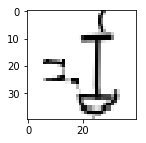

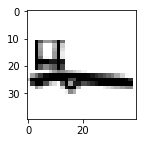

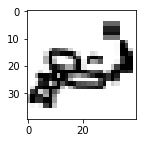

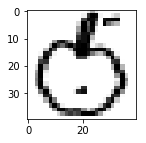

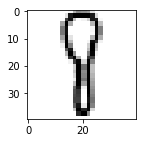

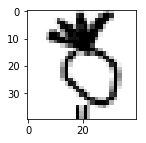

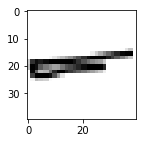

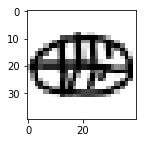

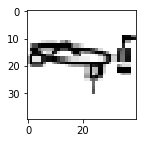

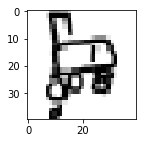

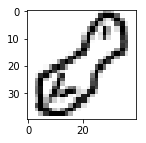

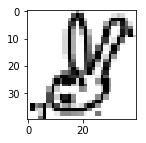

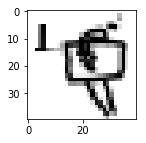

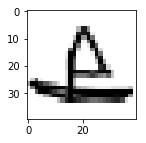

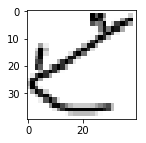

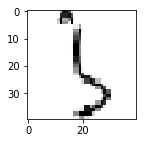

In [4]:
for idx in range(len(theoProcessed_ImgSet)):
    if idx > 15:
        break
    
    # SHow image
    plt.figure(figsize=(2,2))
    plt.imshow(theoProcessed_ImgSet[idx], cmap='gray_r')
    plt.show()

In [24]:
# Manually add noise
N_NOISE = 600
NOISE_INTENSITY = 225

noisy_imgSet = np.empty(np.shape(theoProcessed_ImgSet))

for i, curImg in enumerate(theoProcessed_ImgSet):
    # Generate noise locations
    noise_rowCoords = np.random.randint(0,40, N_NOISE)
    noise_colCoords = np.random.randint(0,40, N_NOISE)
    
    # Iterate over pixels to add noise
    noisy_curImg = np.copy(curImg)
    for j in range(N_NOISE):
        noisy_curImg[noise_rowCoords[j],noise_colCoords[j]] = NOISE_INTENSITY
        
    # Save picture
    noisy_imgSet[i] = noisy_curImg


print(np.shape(noisy_imgSet))

(10000, 40, 40)


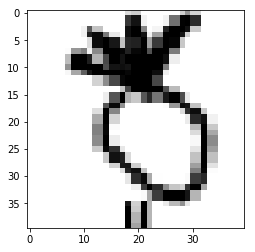

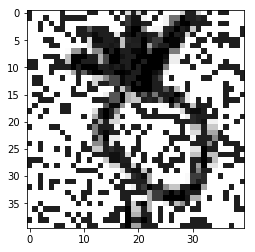

In [25]:
randIdx = 5

plt.imshow(theoProcessed_ImgSet[randIdx], cmap='gray_r')
plt.show()
plt.imshow(noisy_imgSet[randIdx], cmap='gray_r')
plt.show()

## Normalization

In [40]:
# Scale clean data
scaled_theo_imgSet = theoProcessed_ImgSet / np.max(theoProcessed_ImgSet)
print(np.shape(scaled_theo_imgSet))


# Scale noisy data
scaled_noisy_imgSet = noisy_imgSet / np.max(noisy_imgSet)
print( np.shape(scaled_noisy_imgSet) )

(10000, 40, 40)
(10000, 40, 40)


In [41]:
# Expand dimensions
expa_scaled_theo_imgSet = np.expand_dims(scaled_theo_imgSet, axis=3)
print(np.shape(expa_scaled_theo_imgSet))

expa_scaled_noisy_imgSet = np.expand_dims(scaled_noisy_imgSet, axis=3)
print(np.shape(expa_scaled_noisy_imgSet))

(10000, 40, 40, 1)
(10000, 40, 40, 1)


# Auto-encoding

### Package import from tensorflow

In [37]:
from __future__ import print_function
import tensorflow as tf
#from tensorflow import keras

import keras
from keras import layers

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Dropout, Flatten
from keras.layers.normalization import BatchNormalization


/Users/anthony/anaconda3/envs/ImgCV/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Define model
Tutorial: https://blog.keras.io/building-autoencoders-in-keras.html

Some guidance code: https://gist.github.com/naotokui/b9fb93b8dba534b55a140e8c88ce07f5

In [ ]:
def denseMLP():
    imgVecDim = 2500
    
    input_img = Input(shape=(imgVecDim,))
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)

    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(imgVecDim, activation='sigmoid')(decoded)
    
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.summary()
    
    return model

In [ ]:
dense_encoder = denseMLP()

In [ ]:
dense_encoder.fit(downSamp_imageVecSet, downSamp_imageVecSet,
                  epochs=3,
                  batch_size=10,
                  shuffle=True
                 )

In [ ]:
# Show result
pred_vecs = dense_encoder.predict(downSamp_imageVecSet)

np.shape(pred_vecs)

In [ ]:
randIdx = 5

curPredImg = np.reshape(pred_vecs[randIdx], (reduced_dimension,reduced_dimension) )

plt.imshow(curPredImg,cmap='gray_r')
plt.show()

### Better model

In [62]:
def convAutoencoder():
    input_img = Input(shape=(40, 40,1))  # adapt this if using `channels_first` image data format
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    
    autoencoder.summary()
    
    return autoencoder

In [63]:
conv_encoder = convAutoencoder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 40, 40, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 20, 20, 32)        0         
__________

In [64]:
# Take a subset for training
N_SUBSET = 800

noisy_subset = expa_scaled_noisy_imgSet[0:N_SUBSET]
clean_subset = expa_scaled_theo_imgSet[0:N_SUBSET]

print(np.shape(noisy_subset))
print(np.shape(clean_subset))

(800, 40, 40, 1)
(800, 40, 40, 1)


In [65]:
history = conv_encoder.fit(noisy_subset, clean_subset,
                           epochs=20,
                           batch_size=32,
                           shuffle=True,
                          )

Epoch 1/20
800/800 [==============================] - 12s 15ms/step - loss: 0.1304
Epoch 2/20
800/800 [==============================] - 11s 14ms/step - loss: 0.0936
Epoch 3/20
800/800 [==============================] - 11s 14ms/step - loss: 0.0780
Epoch 4/20
800/800 [==============================] - 11s 14ms/step - loss: 0.0651
Epoch 5/20
800/800 [==============================] - 11s 14ms/step - loss: 0.0571
Epoch 6/20
800/800 [==============================] - 12s 15ms/step - loss: 0.0514
Epoch 7/20
800/800 [==============================] - 12s 15ms/step - loss: 0.0479
Epoch 8/20
800/800 [==============================] - 11s 14ms/step - loss: 0.0459
Epoch 9/20
800/800 [==============================] - 12s 14ms/step - loss: 0.0421
Epoch 10/20
800/800 [==============================] - 11s 14ms/step - loss: 0.0419
Epoch 11/20
800/800 [==============================] - 11s 14ms/step - loss: 0.0397
Epoch 12/20
800/800 [==============================] - 11s 14ms/step - loss: 0.0378
E

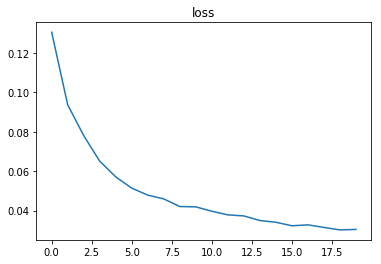

In [67]:
# Visualize loss
plt.plot(history.history['loss'])
plt.title("loss")
plt.show()

In [68]:
# checkout performance
pred_noisy_set = conv_encoder.predict(noisy_subset)
print(np.shape(pred_noisy_set))

(800, 40, 40, 1)


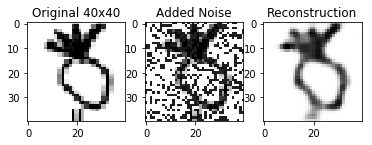

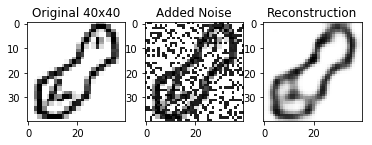

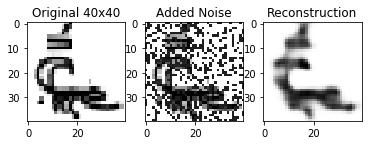

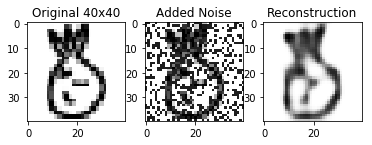

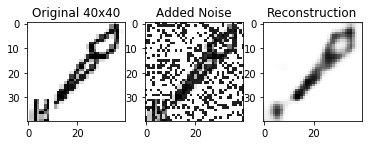

In [71]:
randIdx_list = [5, 10, 23, 45, 80]

for rand_i in randIdx_list:
    plt.subplot(1,3,1)
    plt.imshow(clean_subset[rand_i,:,:,0], cmap='gray_r')
    plt.title("Original 40x40")
    
    plt.subplot(1,3,2)
    plt.imshow(noisy_subset[rand_i,:,:,0], cmap='gray_r')
    plt.title("Added Noise")
    
    plt.subplot(1,3,3)
    plt.imshow(pred_noisy_set[rand_i,:,:,0], cmap='gray_r')
    plt.title("Reconstruction")
    plt.show()

In [72]:
# Applying the same denoiser to the original clean input
pred_clean_set = conv_encoder.predict(clean_subset)
print(np.shape(pred_clean_set))

(800, 40, 40, 1)


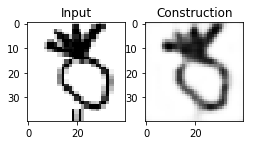

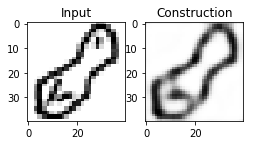

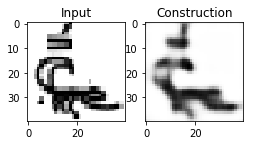

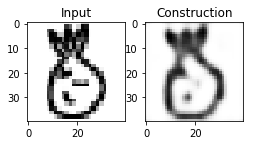

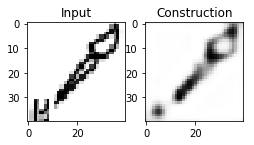

In [73]:
randIdx_list = [5, 10, 23, 45, 80]

for rand_i in randIdx_list:
    plt.subplot(1,3,1)
    plt.imshow(clean_subset[rand_i,:,:,0], cmap='gray_r')
    plt.title("Input")
    
    plt.subplot(1,3,2)
    plt.imshow(pred_clean_set[rand_i,:,:,0], cmap='gray_r')
    plt.title("Construction")
    plt.show()